## Training a variational classifier

In this notebook, we show how to train variational quantum circuits using labelled data. We will use data from the Sloan Digitial Sky Survey, Data release 16(SDSS DR16) catalogue data. The survey provides photometric fluxes and redshifts of astronomical objects like galaxies, stars & quasars. We use a subsample of 400 samples out of which 200 are stars and rest is galaxies. 

We first import the required modules: PennyLane, PennyLane-provided version of NumPy, the adam optimizer,pandas and sklearn preprocessing functions

In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer,AdamOptimizer ##remove
import pandas as pd
import torch
from torch.nn.functional import relu
from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pennylane as qml
from pennylane.templates import AngleEmbedding, StronglyEntanglingLayers
from pennylane.operation import Tensor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


First, we create a quantum device with 2 qubits.

In [2]:
dev = qml.device("default.qubit", wires=2)

<ul>We will perform amplitude encoding. To do this we create 2 functions : "transform" and "statepreparation".
    <li>"transform" : map the 4 dimensional feature vector to 5 dimensional vector of angles.</li>
    <li>"statepreparation" : encode the angle vector into the qubits.</li>

In [3]:
def transform(x):
    x0 = 2*np.arcsin(np.sqrt(x[1]**2)/np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    x1 = 2*np.arcsin(np.sqrt(x[3]**2)/np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    x2 = 2*np.arcsin(np.sqrt(x[2]**2 + x[3] ** 2)/np.sqrt(x[0] ** 2 + x[1] ** 2 + x[2] ** 2 + x[3] ** 2))
    return np.array([x2, -x1 / 2, x1 / 2, -x0 / 2, x0 / 2])

In [4]:
def statepreparation(a):
    qml.RY(a[0], wires=0)

    qml.CNOT(wires=[0, 1])
    qml.RY(a[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[2], wires=1)

    qml.PauliX(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[3], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[4], wires=1)
    qml.PauliX(wires=0)

Below you can see how the encoding looks, (where elements of a are all taken to be pi/2)

![](statepreparation.png)

The state preparation routine will followed by a repetition of a layer structure. Layers are an elementary circuit architecture which is repeated to build a variational circuit.

Our circuit layer will consist of an arbitrary rotation on every qubit, where the rotation angles are the weights of the circuit to be optimised. This will be followed by a CNOT that entangles the first qubit with its neighbour.

In [5]:
def layer(W):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.CNOT(wires=[0, 1])

We now define the quantum circuit which takes the features(angles) and weights as input, and returns the expectation value of the 1st qubit as the output.

In [6]:
@qml.qnode(dev)
def circuit(weights, angles):
    statepreparation(angles)
    for W in weights:
        layer(W)
    return qml.expval(qml.PauliZ(0))

We now add a 'classical' bias term to the output of the circuit

In [7]:
def variational_classifier(weights, bias, angles):
    return circuit(weights, angles) + bias

Lets draw the circuit to better visualize whats happening inside

In [8]:
drawer = qml.draw(circuit)
w,a=np.random.randn(1,2, 3),np.random.randn(5)
print(drawer(w,a))
print('|','-'*32,'encoding','-'*32,'|','-'*11,'layer','-'*10,'|','measurement')

 0: ──RY(-0.514)──╭C─────────────╭C──X───────────╭C────────────╭C──X───────────Rot(-1.24, 0.134, -1.36)──╭C──┤ ⟨Z⟩ 
 1: ──────────────╰X──RY(0.167)──╰X──RY(-0.187)──╰X──RY(1.48)──╰X──RY(-0.964)──Rot(0.208, 0.122, 0.552)──╰X──┤     

| -------------------------------- encoding -------------------------------- | ----------- layer ---------- | measurement


Here we show a variational circuit with just one layer.In the actual circuit that we'll use, there will be 6 such layers. Each layer has 6 weights, so the circuit has total 36+1 weights and bias to train.

Below we show the general structure of Variational quantum classifiers.  (source:https://arxiv.org/abs/2105.10162v1)

<img src="VQC.png" width="600"/>

Next, to be able to train the circuit, we need to define a cost function. Here, the cost function is mean squared error

In [9]:
def MSE(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2
    loss = loss / len(labels)
    return loss
def cost(weights, bias, features, labels):
    predictions = [variational_classifier(weights, bias, f) for f in features]
    return MSE(labels, predictions)

The accuracy informs the fraction of samples that were correctly predicted.

In [10]:
def accuracy(labels, predictions):
    count = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            count = count + 1
    frac = count/len(labels)
    return frac

We now load the data

In [26]:
data=pd.read_csv('400_data.csv')[['u','g','r','i','z','class','redshift']]

In [27]:
data['class'].replace(0,-1,inplace=True)

The five SDSS ugriz filters-'u','g','r','i','z' are the intensities of light obtained in the 5 wavelength bands of the telescope. The effective wavelength range is ~350 nm to ~920 nm. 'redshift' informs the estimated redshift of the object.

A value of -1 in the class column means the object is a star, while 1 means its a galaxy.

For the present problem, we use the 'u','r','z' & redshift of the object as the features, and 'class' as the target to be predicted.The dataset is equally divided into stars and galaxies, hence an accuracy of >50% will mean that the classifier has learnt something useful.

In [28]:
scaler=MinMaxScaler()
X,Y=scaler.fit_transform(data[['u','r','z','redshift']]),data['class'].values
normalization = np.sqrt(np.sum(X ** 2, -1))
X_norm = (X.T / normalization).T
features = np.array([transform(x) for x in X_norm], requires_grad=False)

We now divide the dataset into training and validation datasets with a 3:1 split.

In [15]:
feats_train, feats_val, Y_train, Y_val = train_test_split(features,Y,test_size=0.25)

<ul>Now for the final step - training. We will use the adam optimizer and define the mini batch size to be 150, i.e. the number of samples to use for training at every step.
    <li>Initialize the weights of the circuit to random values. The bias can be initialized to a zero or random float.</li>
    <li>Optimize the weights by iterating over a loop, in which the optimizer calculates new weights using the previous weights and corresponding cost.</li>
You can also perform hyperparameter optimization, i.e. find the best learning rate, number of layers etc. to achieve the best results.

In [16]:
learning_rate=0.05
opt = AdamOptimizer(learning_rate)
batch_size = 150
n_qubits,n_layers = 2,6
weights = 0.01 * np.random.randn(n_layers, n_qubits, 3, requires_grad=True)
bias = np.array(0.0, requires_grad=True)
best_w,best_b,best_v=weights,bias,0
AV,AT=[],[]

for it in range(25):
    batch_index = np.random.randint(0, len(Y_train), (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, feats_train_batch, Y_train_batch)

    predictions_train = [np.sign(variational_classifier(weights, bias, f)) for f in feats_train]
    predictions_val = [np.sign(variational_classifier(weights, bias, f)) for f in feats_val]

    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)
    AV.append(acc_val);AT.append(acc_train)
    
    if acc_val>best_v: best_w,best_b,best_v=weights,bias,acc_val
    
    print("Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f}""".format(it + 1, cost(weights, bias, features, Y), acc_train, acc_val)
    )
print("highest accuracy in validation-{:0.7f}%""".format(best_v*100))

C:\Users\Dheeru\Anaconda3\envs\vk\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.21.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.2778590 | Acc train: 0.5100000 | Acc validation: 0.4700000
Iter:     2 | Cost: 1.1481519 | Acc train: 0.5633333 | Acc validation: 0.5000000
Iter:     3 | Cost: 0.9713960 | Acc train: 0.6166667 | Acc validation: 0.5800000
Iter:     4 | Cost: 0.7687437 | Acc train: 0.7366667 | Acc validation: 0.7100000
Iter:     5 | Cost: 0.6197160 | Acc train: 0.7966667 | Acc validation: 0.8300000
Iter:     6 | Cost: 0.5378873 | Acc train: 0.8300000 | Acc validation: 0.8400000
Iter:     7 | Cost: 0.5013341 | Acc train: 0.8600000 | Acc validation: 0.8400000
Iter:     8 | Cost: 0.4739021 | Acc train: 0.8600000 | Acc validation: 0.8500000
Iter:     9 | Cost: 0.4451919 | Acc train: 0.8600000 | Acc validation: 0.8400000
Iter:    10 | Cost: 0.4090217 | Acc train: 0.8800000 | Acc validation: 0.8300000
Iter:    11 | Cost: 0.3590189 | Acc train: 0.9033333 | Acc validation: 0.8800000
Iter:    12 | Cost: 0.3222441 | Acc train: 0.9300000 | Acc validation: 0.9300000
Iter:    13 | Cost: 0.317788

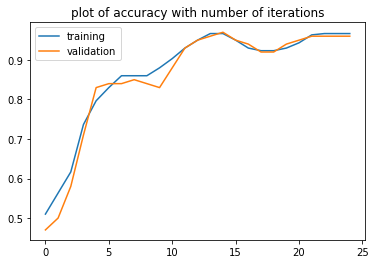

In [17]:
plt.figure()
plt.plot(AT,label='training')
plt.plot(AV,label='validation')
plt.title('plot of accuracy with number of iterations')
plt.legend()

## Training a SVM classifier using quantum kernels

In kernel based training, first the data is encode to quantum states using a feature map. The strategy is to use a feature map from the space of data to a feature space of density matrices, where the quantum models can be expressed as linear models with a decision boundary defined by the measurement.

The difference between kernel based training and variational quantum circuits is that, in the latter, the training of the quantum model is done variationally, whereas in the former, we train an equivalent classical kernel method with a kernel(feature mapping) executed on a quantum device.

Below we show the difference in the structure of both methods, where VQC is shown in left and Kernel based training on the right. (source:https://pennylane.ai/qml/demos/tutorial_kernel_based_training.html)

<img src="kernel.png" width="600"/>

Lets create the features and targets. This time, lets use the standard scaler-i.e. scale the data such that the variance of data is 1. Next divide the data into 3:1 train:test split.

In [18]:
scaler=StandardScaler()
X,Y=scaler.fit_transform(data[['u','r','z','redshift']]),data['class'].values

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.25)

We will implement the kernel by preparing states using angle encoding. Angle encoding means the features will directly be mapped to an angle. The quantum state in the circuit will be rotated about X axis by this angle to encode the features. The number of qubits needed for this is the same as number of features.

The kernel will require the two states |ϕ(x)⟩, |ϕ(x′)⟩ using angle-embedding routines S(x),S(x′) respectively. It will yield the their overlap with a small routine called a SWAP test. We then measure the projector onto the initial state |0..0⟩⟨0..0|. The kernel will send the evaluations for samples in two different datasets A, B to the kernel method, which in our case is a Support Vector Machine.

In [20]:
n_qubits=4
dev_kernel = qml.device("default.qubit", wires=n_qubits)

projector = np.zeros((2**n_qubits, 2**n_qubits))
projector[0, 0] = 1

@qml.qnode(dev_kernel)
def kernel(x1, x2):
    AngleEmbedding(x1, wires=range(n_qubits))
    qml.adjoint(AngleEmbedding)(x2, wires=range(n_qubits))
    return qml.expval(qml.Hermitian(projector, wires=range(n_qubits)))

In [21]:
dev = qml.device("default.qubit", wires=2)

In [22]:
def kernel_matrix(A, B):
    return np.array([[kernel(a, b) for b in B] for a in A])

Define the Support Vector Machine with our quantum kernel and fit it to the training dataset.

In [23]:
svm = SVC(kernel=kernel_matrix).fit(X_train, y_train)

Make predictions on the test dataset and output the accuracy.

In [24]:
predictions = svm.predict(X_test)
accuracy_score(predictions, y_test)

0.98